<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

## Image segmentation with a U-Net-like architecture

In [1]:
import matplotlib.pyplot as plt
import os,math, random
from skimage.transform import resize as sc_resize
import matplotlib.pyplot as plt
import cv2
from skimage import io
import numpy as np
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline
plt.rcParams['image.cmap']='gray'
tf.random.set_seed(1000)
np.random.seed(1000)
plt.ion()

In [2]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  11.0M      0  0:01:08  0:01:08 --:--:-- 11.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4133k      0  0:00:04  0:00:04 --:--:-- 4133k


In [3]:
input_dir = "./images/"
target_dir = "./annotations/trimaps/"
input_img_paths=sorted(
                    [ os.path.join(input_dir,img_name)for img_name in os.listdir(input_dir) if img_name.endswith('.jpg') ]
                    )

target_img_paths=sorted(
                  [ os.path.join(target_dir,tar_img_name) for tar_img_name in os.listdir(target_dir)
                   if tar_img_name.endswith('.png') and not tar_img_name.startswith('.')
                  ])
len(input_img_paths)

7390

In [20]:
K.backend.clear_session()
img_size = (160,160)
num_classes = 3
batch_size = 50

class OxfordPetsDateset(K.utils.Sequence):
    def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.input_img_paths=input_img_paths
        self.target_img_paths=target_img_paths
        
        
    def __len__(self):
        return len(self.target_img_paths)//self.batch_size
    
    def __getitem__(self,idx):
        batch_input_img_paths=self.input_img_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_paths=self.target_img_paths[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x=np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        batch_y=np.zeros((self.batch_size,)+self.img_size+(1,),dtype='uint8')
        
        for i,img in enumerate(batch_input_img_paths):
            img=load_img(img, target_size=self.img_size)
            img/=np.max(img)
            batch_x[i]=img
            
        for i,img in enumerate(batch_target_img_paths):
            img=load_img(img, target_size=self.img_size, color_mode="grayscale")
            batch_y[i]=np.expand_dims(img,axis=2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            batch_y[i]-=1
        return batch_x,batch_y
        


In [21]:

# Split our img paths into a training and a validation set
val_samples = 1000
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]
# Instantiate data Sequences for each split
train_data = OxfordPetsDateset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_data = OxfordPetsDateset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

# MODEL
We will implement a U-Net-like architecture but with fewer layers

In [22]:
K.backend.clear_session()

In [23]:
def block(x_inputs,filters):
    con_1=K.layers.Conv2D(filters,kernel_size=3,padding = 'same' )(x_inputs)
    b1=K.layers.BatchNormalization()(con_1)
    act1=K.layers.Activation('relu')(b1)
    
    con_2=K.layers.Conv2D(filters,kernel_size=3,padding = 'same' )(act1)
    b2=K.layers.BatchNormalization()(con_2)
    act2=K.layers.Activation('relu')(b2)
    return act2

def encoder(inputs,filters):
    en_block=block(inputs,filters)
    m_pool=K.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same')(en_block)
    return en_block,m_pool

def decoder(inputs,skips,filters):
    upsample=K.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    merge=K.layers.Concatenate()([skips,upsample])
    de_block=block(merge,filters)
    return de_block

In [24]:
def Unet(size):
    x_input =K.Input(size)
    skip_1,encoder1=encoder(x_input,20)
    skip_2,encoder2=encoder(encoder1,160)
    #
    con_block=block(encoder2,10)
    #
    decoder1=decoder(con_block,skip_2,160)
    decoder2=decoder(decoder1,skip_1,20)    
    output=K.layers.Conv2D(3,1,padding='same',activation ='softmax')(decoder2)
    model=K.Model(inputs=x_input,outputs=output)
    model.compile(optimizer = K.optimizers.Adam(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy')
    return model

In [25]:
input_shape = (160,160, 3)
net=Unet(input_shape)

In [26]:
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 20  560         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 20  80         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [27]:
#net.fit(train_data,target_data,steps_per_epoch=1000,epochs=20)
net.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
127/127 [==============================] - 151s 1s/step - loss: 0.9449 - val_loss: 1.0190
Epoch 2/15
127/127 [==============================] - 133s 1s/step - loss: 0.7705 - val_loss: 0.8612
Epoch 3/15
127/127 [==============================] - 134s 1s/step - loss: 0.7027 - val_loss: 0.6883
Epoch 4/15
127/127 [==============================] - 133s 1s/step - loss: 0.6601 - val_loss: 0.7012
Epoch 5/15
127/127 [==============================] - 134s 1s/step - loss: 0.6345 - val_loss: 0.5836
Epoch 6/15
127/127 [==============================] - 133s 1s/step - loss: 0.6019 - val_loss: 0.5660
Epoch 7/15
127/127 [==============================] - 134s 1s/step - loss: 0.5826 - val_loss: 0.5133
Epoch 8/15
127/127 [==============================] - 134s 1s/step - loss: 0.5604 - val_loss: 0.5105
Epoch 9/15
127/127 [==============================] - 134s 1s/step - loss: 0.5506 - val_loss: 0.5117
Epoch 10/15
127/127 [==============================] - 134s 1s/step - loss: 0.5398 - val_lo

In [28]:
net.save("unet_model_OxfordPet.h5")

In [29]:
model=K.models.load_model("unet_model_OxfordPet.h5")

In [30]:
# Generate predictions for all images in the validation set

val_gen = OxfordPetsDateset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

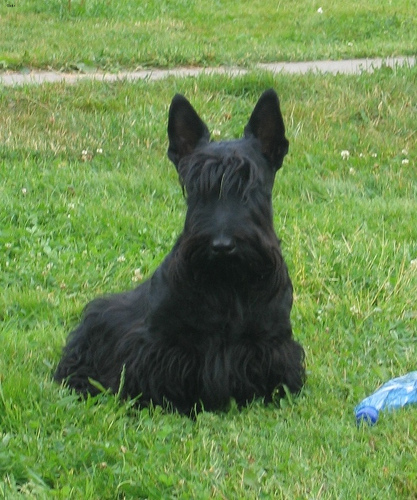

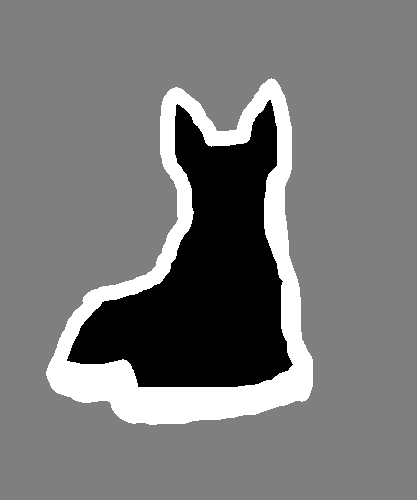

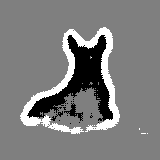

In [31]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(K.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

# References

[U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015](https://arxiv.org/pdf/1505.04597.pdf)

[Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

[A guide to convolution arithmetic for deep learning,2018](https://arxiv.org/abs/1603.07285)

[Is the deconvolution layer the same as a convolutional layer?,2016](https://arxiv.org/ftp/arxiv/papers/1609/1609.07009.pdf)

[13.11. Fully Convolutional Networks](https://d2l.ai/chapter_computer-vision/fcn.html)


